In [1]:
# Requirements 
# !pip3 install pandas numpy seaborn 
# !python3 -m pip install "dask[complete]" --upgrade
# !python3 -m pip install "dask[array]" --upgrade
# !python3 -m pip install "dask[bag]" --upgrade
# !python3 -m pip install "dask[dataframe]" --upgrade
# !python3 -m pip install "dask[delayed]" --upgrade
# !python3 -m pip install "dask[distributed]" --upgrade
import os
import numpy as np
import pandas as pd
# import dask.dataframe as dd
import math
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# available months (file labels)
df_labels = ['2019-Oct', '2019-Nov']

In [ ]:
# Below is some stuff which is used for debug only, proceed straigt to RQ1 -------------------------------------->

In [3]:
# TO DO: remove, not used
october_df = pd.read_csv(
    "datasets/2019-Oct.csv",
    parse_dates=['event_time'],
    date_parser=pd.to_datetime,
    nrows=1000
)
october_df.head(20)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
5,2019-10-01 00:00:05+00:00,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9
6,2019-10-01 00:00:08+00:00,view,17300353,2053013553853497655,NaN,creed,380.96,555447699,4fe811e9-91de-46da-90c3-bbd87ed3a65d
7,2019-10-01 00:00:08+00:00,view,31500053,2053013558031024687,NaN,luminarc,41.16,550978835,6280d577-25c8-4147-99a7-abc6048498d6
8,2019-10-01 00:00:10+00:00,view,28719074,2053013565480109009,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880
9,2019-10-01 00:00:11+00:00,view,1004545,2053013555631882655,electronics.smartphone,huawei,566.01,537918940,406c46ed-90a4-4787-a43b-59a410c1a5fb


In [8]:
# TODO: remove, not used, may be useful
october_df.groupby(['event_type', 'category_code']).size().reset_index(name='counts')

,event_type,category_code,counts
0,cart,electronics.audio.headphone,1
1,cart,electronics.smartphone,1
2,purchase,appliances.environment.air_heater,1
3,purchase,electronics.audio.headphone,3
4,purchase,electronics.smartphone,4
5,purchase,furniture.bathroom.toilet,1
6,view,accessories.bag,1
7,view,apparel.shoes,11
8,view,apparel.shoes.keds,14
9,view,apparel.shoes.slipons,1


In [17]:
# TODO: remove, not used
# Categories are composed of multiple subcategories, from NaN up to 4
nov_categories = november_df.copy()
# nov_categories['category_code'].dropna().str.split('.', expand=True)
nov_categories['category_code'].str.split('.', expand=True).drop_duplicates().sort_values(
    by=list(range(4)), ascending=True
).head(20)

,0,1,2,3
90,accessories,bag,None,None
1504,accessories,wallet,None,None
259,apparel,costume,None,None
1869,apparel,dress,None,None
53,apparel,jeans,None,None
1898,apparel,jumper,None,None
197,apparel,shirt,None,None
3415,apparel,shoes,ballet_shoes,None
803,apparel,shoes,keds,None
890,apparel,shoes,moccasins,None


In [337]:
# <-------------------------------------------------------------------------- Debug has ended here

# RQ1

A marketing **funnel** describes your customer’s journey with your e-commerce. 

It may involve different stages, beginning when someone learns about your business, when he/she visits your website for the first time, to the purchasing stage, marketing funnels map routes to conversion and beyond.

Suppose your funnel involves just three simple steps: 

1) view, 
2) cart, 
3) purchase. 


- **Which is the rate of complete funnels**?


- **What’s the operation users repeat more on average within a session?** Produce a plot that shows the average number of times users perform each operation (view/removefromchart etc etc).


- **How many times, on average, a user views a product before adding it to the cart?**


- **What’s the probability that products added once to the cart are effectively bought?**


- **What’s the average time an item stays in the cart before being removed?**


- **How much time passes on average between the first view time and a purchase/addition to cart?**

## Which is the rate of complete funnels? 

We should sort by event time, consider user id, product id and event type


Theoretically if user viewed a product put in into the cart another day and purchased another day the funnel is still complete, only order matters

There are inconsistent funnels where after viewing person can buy it without putting into a cart -> complete funnels are the ones that lead to a purchase

In [88]:
def get_complete_funnels_rate(df_label='2019-Oct', chunksize=1_000):
    # Take only needed columns such as 'user_id', 'product_id', 'event_time'
    # user_id, product_id: np.uint16 ~ [0, 4294967295] | could take less space if would have been normalized
    # dataset have been already sorted by event_time, we can skip uploading that column
    reader = pd.read_csv(
        f"datasets/{df_label}.csv",
        usecols=['user_id', 'product_id', 'event_type'],
        dtype={'user_id': np.uint32, 'product_id': np.uint32, 'event_type': str},
        engine='c',
        na_filter=False,
        memory_map=True,
        chunksize=chunksize,
        nrows=10_000
    )
    events_handler = pd.DataFrame()
    i = 0
    for chunk in reader:
        print(f"Processing a chunk #{i}")
        events_operations = chunk[chunk['event_type'].isin(['view', 'purchase'])].groupby(
            ['user_id', 'product_id', 'event_type']
        ).event_type.count().to_frame().rename(
            columns={'event_type': 'n_events'}
        )
        if events_handler.empty:
            events_handler = events_operations
        else:
            events_handler = events_handler.add(events_operations, fill_value=0).astype(np.uint32)
        i += 1
    events_handler = events_handler.reset_index()
    complete_funnel = sum(events_handler['event_type'] == 'purchase')
    product_user_pairs = sum(events_handler['event_type'] == 'view')
    print(f"{df_label + ' | ' if df_label else ''}Complete funnels: {complete_funnel} out of {product_user_pairs}")
    rate = int(round(complete_funnel / product_user_pairs, 2) * 100) if product_user_pairs > 0 else 0
    print(f"{df_label + ' | ' if df_label else ''}Rate of complete funnels: {rate}%")

In [89]:
for df_label in df_labels:
    get_complete_funnels_rate(df_label=df_label)

Processing a chunk #0
Processing a chunk #1
Processing a chunk #2
Processing a chunk #3
Processing a chunk #4
Processing a chunk #5
Processing a chunk #6
Processing a chunk #7
Processing a chunk #8
Processing a chunk #9
2019-Oct | Complete funnels: 117 out of 7026
2019-Oct | Rate of complete funnels: 2%
Processing a chunk #0
Processing a chunk #1
Processing a chunk #2
Processing a chunk #3
Processing a chunk #4
Processing a chunk #5
Processing a chunk #6
Processing a chunk #7
Processing a chunk #8
Processing a chunk #9
2019-Nov | Complete funnels: 86 out of 6723
2019-Nov | Rate of complete funnels: 1%


## What’s the operation users repeat more on average within a session? 
Produce a plot that shows the average number of times users perform each operation (view/etc).

In [203]:
def most_repeated_operation(df_label='2019-Oct', chunksize=1_000):
    reader = pd.read_csv(
        f"datasets/{df_label}.csv",
        usecols=['user_session', 'event_type'],
        dtype={'user_id': str, 'product_id': np.uint32},
        engine='c',
        na_filter=False,
        memory_map=True,
        chunksize=chunksize,
        nrows=10_000
    )
    sessions_handler = pd.DataFrame()
    i = 0
    for chunk in reader:
        print(f"Processing a chunk #{i}")        
        session_operations = chunk.groupby(
            ['user_session', 'event_type']
        ).event_type.count().to_frame().rename(
            columns={'event_type': 'n_events'}
        )
        # important to fill with 0 absent events
        session_operations = session_operations.reindex(
            pd.MultiIndex.from_product(
                [session_operations.index.levels[0], ['view', 'cart', 'purchase']], 
                names=['user_session', 'event_type']
            ),
            fill_value=0
        )
        
        if sessions_handler.empty:
            sessions_handler = session_operations
        else:
            sessions_handler = sessions_handler.add(session_operations, fill_value=0).astype(np.uint32)
        i += 1
    sessions_handler = sessions_handler.reset_index()
    # Average number of times users perform each operation (within a session)
    session_operations_avg = sessions_handler.groupby(
        ['event_type']
    ).n_events.mean().to_frame().reset_index().sort_values(by=['n_events'], ascending=False)
    print(f"{df_label + ' | ' if df_label else ''}Summary")
    print(session_operations_avg.head(5))
    _ = sns.barplot(data=session_operations_avg, x="event_type", y="n_events")
    plt.show()

Processing a chunk #0
Processing a chunk #1
Processing a chunk #2
Processing a chunk #3
Processing a chunk #4
Processing a chunk #5
Processing a chunk #6
Processing a chunk #7
Processing a chunk #8
Processing a chunk #9
2019-Oct | Summary
  event_type  n_events
2       view  3.069322
1   purchase  0.037014
0       cart  0.030427


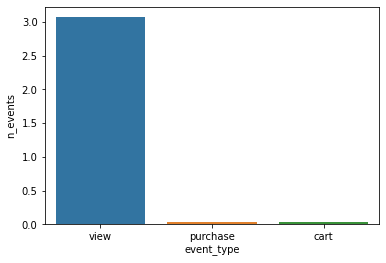

Processing a chunk #0
Processing a chunk #1
Processing a chunk #2
Processing a chunk #3
Processing a chunk #4
Processing a chunk #5
Processing a chunk #6
Processing a chunk #7
Processing a chunk #8
Processing a chunk #9
2019-Nov | Summary
  event_type  n_events
2       view  4.002041
1   purchase  0.041633
0       cart  0.037959


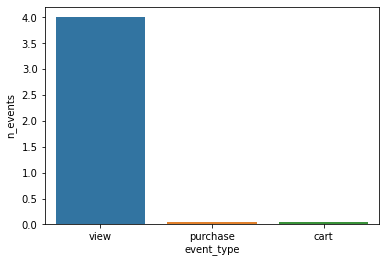

In [204]:
for df_label in df_labels:
    most_repeated_operation(df_label=df_label)

## How many times, on average, a user views a product before adding it to the cart?

In [201]:
def get_avg_n_of_views_for_view_cart_funnels(df_label='2019-Oct', chunksize=1_000):
    reader = pd.read_csv(
        f"datasets/{df_label}.csv",
        usecols=['user_id', 'product_id', 'event_type'],
        dtype={'user_id': np.uint32, 'product_id': np.uint32, 'event_type': str},
        engine='c',
        na_filter=False,
        memory_map=True,
        chunksize=chunksize,
        nrows=10_000
    )
    events_handler = pd.DataFrame()
    i = 0
    for chunk in reader:
        print(f"Processing a chunk #{i}")
        events_operations = chunk[chunk['event_type'].isin(['view', 'cart'])].groupby(
            ['user_id', 'product_id', 'event_type']
        ).event_type.count().to_frame().rename(
            columns={'event_type': 'n_events'}
        )
        if events_handler.empty:
            events_handler = events_operations
        else:
            events_handler = events_handler.add(events_operations, fill_value=0).astype(np.uint32)
        i += 1
    events_handler = events_handler.reset_index(level=2)
    events_handler = events_handler.loc[events_handler[events_handler['event_type'] == 'cart'].index, :]
    # normalize by number of times product has been put into a cart and find mean
    avg_n_times_viewed_before_cart = (
        events_handler.loc[events_handler['event_type'] == 'view', 'n_events'] 
        / events_handler.loc[events_handler['event_type'] == 'cart', 'n_events']
    ).mean()
    print(
        f"{df_label + ' | ' if df_label else ''}"
        f"A user views a product before adding it to the cart in average "
        f"{round(avg_n_times_viewed_before_cart, 3)} times"
    )

In [202]:
for df_label in df_labels:
    get_avg_n_of_views_for_view_cart_funnels(df_label=df_label)

Processing a chunk #0
Processing a chunk #1
Processing a chunk #2
Processing a chunk #3
Processing a chunk #4
Processing a chunk #5
Processing a chunk #6
Processing a chunk #7
Processing a chunk #8
Processing a chunk #9
2019-Oct | A user views a product before adding it to the cart in average 1.994 times
Processing a chunk #0
Processing a chunk #1
Processing a chunk #2
Processing a chunk #3
Processing a chunk #4
Processing a chunk #5
Processing a chunk #6
Processing a chunk #7
Processing a chunk #8
Processing a chunk #9
2019-Nov | A user views a product before adding it to the cart in average 2.286 times


## What’s the probability that products added once to the cart are effectively bought?

In [209]:
def get_probability_that_if_in_cart_product_is_bought(df_label='2019-Oct', chunksize=1_000):
    reader = pd.read_csv(
        f"datasets/{df_label}.csv",
        usecols=['user_id', 'product_id', 'event_type'],
        dtype={'user_id': np.uint32, 'product_id': np.uint32, 'event_type': str},
        engine='c',
        na_filter=False,
        memory_map=True,
        chunksize=chunksize,
        nrows=10_000
    )
    events_handler = pd.DataFrame()
    i = 0
    for chunk in reader:
        print(f"Processing a chunk #{i}")
        events_operations = chunk[chunk['event_type'].isin(['purchase', 'cart'])].groupby(
            ['user_id', 'product_id', 'event_type']
        ).event_type.count().to_frame().rename(
            columns={'event_type': 'n_events'}
        )
        if events_handler.empty:
            events_handler = events_operations
        else:
            events_handler = events_handler.add(events_operations, fill_value=0).astype(np.uint32)
        i += 1
    events_handler = events_handler.reset_index(level=2)
    events_handler = events_handler.loc[events_handler[events_handler['event_type'] == 'cart'].index, :]
    events_sum = events_handler.groupby(
        ['event_type']
    ).n_events.sum().to_frame()
    n_success_events = events_sum.query("event_type == 'purchase'").values[0][0]
    n_total_events = events_sum.query("event_type == 'cart'").values[0][0]
    print(
        f"{df_label + ' | ' if df_label else ''}"
        f"The probability that products added once to the cart are effectively bought "
        f"{round(n_success_events / n_total_events * 100) if n_total_events > 0 else 0}%"
    )

In [211]:
for df_label in df_labels:
    get_probability_that_if_in_cart_product_is_bought(df_label=df_label)

Processing a chunk #0
Processing a chunk #1
Processing a chunk #2
Processing a chunk #3
Processing a chunk #4
Processing a chunk #5
Processing a chunk #6
Processing a chunk #7
Processing a chunk #8
Processing a chunk #9
2019-Oct | The probability that products added once to the cart are effectively bought 36%
Processing a chunk #0
Processing a chunk #1
Processing a chunk #2
Processing a chunk #3
Processing a chunk #4
Processing a chunk #5
Processing a chunk #6
Processing a chunk #7
Processing a chunk #8
Processing a chunk #9
2019-Nov | The probability that products added once to the cart are effectively bought 46%


## What’s the average time an item stays in the cart before being removed?

In [212]:
# TODO: have to deal with time

## How much time passes on average between the first view time and a purchase/addition to cart?

In [213]:
# TODO: have to deal with time

# RQ2

 - **What are the categories of the most trending products overall?** For each month visualize this information through a plot showing the number of sold products per category.  
 
- **Plot the most visited subcategories.**


- **What are the 10 most sold products per category?**

## What are the categories of the most trending products overall?

We consider a product to be tranding if it's selling out well

The initial dataset is too big to be processed directly in pandas, we use a script '*generate_subset_with_n_purchases_per_category.sh*' which
 - makes a subset that contains only purchases
 - finds all unique categories present in the subset
 - for each category calculates number of lines present in the subset
 
Category - is the first value before . separator, the rest are sub-categories

In [242]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    """ Helper to display actual values on barplot """
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width()
                _y = p.get_y() + p.get_height() - float(space)
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [291]:
def get_most_trending_products(df_label='2019-Oct', chunksize=100_000):
    reader = pd.read_csv(
        f"datasets/{df_label}.csv",
        usecols=['category_code', 'event_type'],
        dtype={'category_code': str, 'event_type': str},
        engine='c',
        na_filter=False,
        memory_map=True,
        chunksize=chunksize
    )
    most_trending_products = pd.DataFrame()
    i = 0
    for chunk in reader:
        # print(f"Processing a chunk #{i}")
        # take only the category
        chunk.loc[:, 'category_code'] = chunk.category_code.str.split('.').str[0]
        events_operations = chunk[
            chunk['event_type'].isin(['purchase']) & ~(chunk['category_code'] == '')
        ].dropna().groupby(
            ['category_code']
        ).event_type.count().to_frame().rename(
            columns={'event_type': 'n_purchases'}
        )
        if most_trending_products.empty:
            most_trending_products = events_operations
        else:
            most_trending_products = most_trending_products.add(events_operations, fill_value=0).astype(np.uint32)
        i += 1
    most_trending_products.reset_index(inplace=True)
    # sort in descending order
    most_trending_products.sort_values(by=['n_purchases'], ascending=False, inplace=True)
    # plot results
    fig, ax = plt.subplots(figsize=(15, 10))
    bar_plt = sns.barplot(data=most_trending_products, x="n_purchases", y="category_code", palette='tab10')
    bar_plt.set(
        ylabel='Category', 
        xlabel='Number of purchases', 
        title=f"{df_label + ': ' if df_label else ''}Number of sold products per category"
    )
    show_values_on_bars(ax, "h", 0.3)
    plt.show()

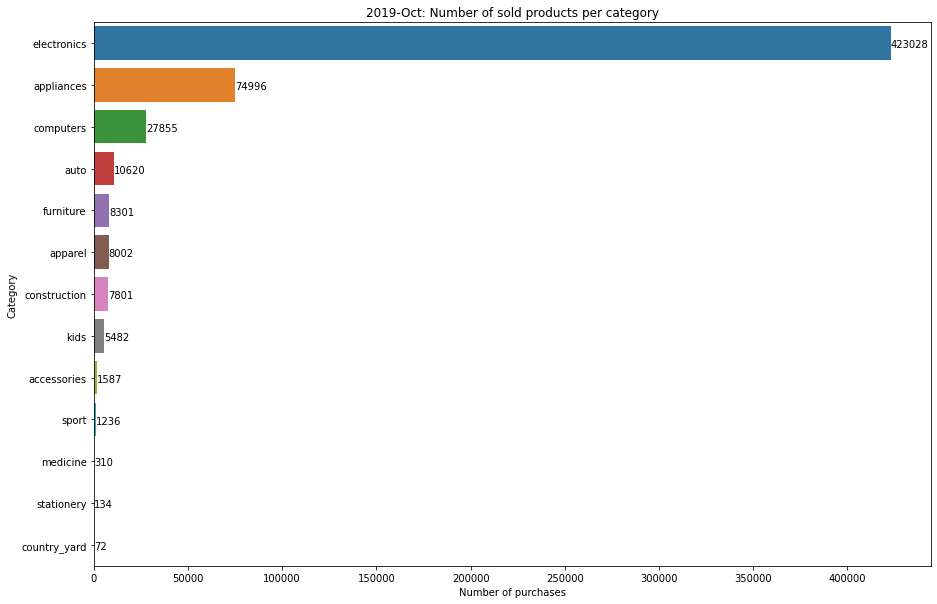

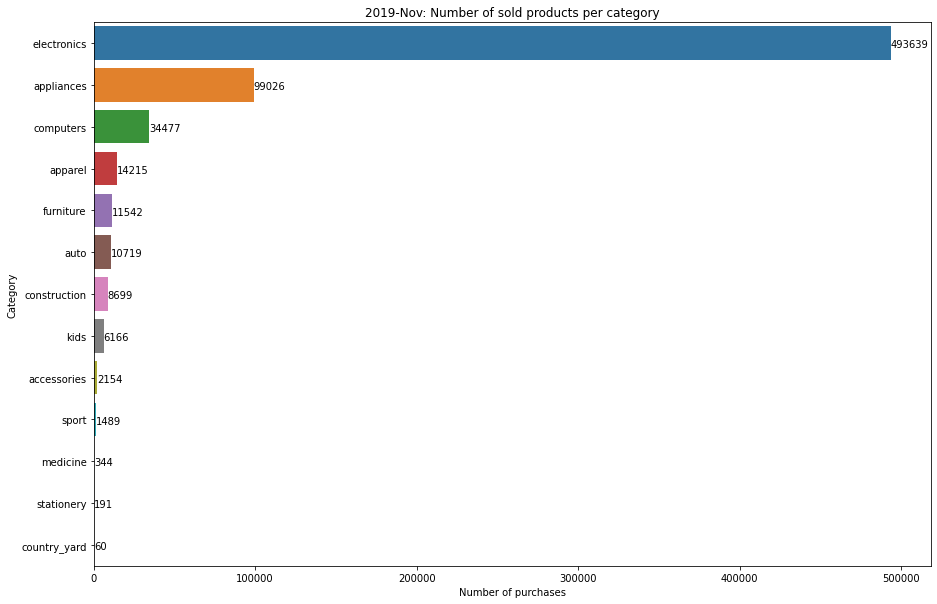

In [292]:
for df_label in df_labels:
    get_most_trending_products(df_label=df_label)

In [4]:
# plan B: use dash library to paralelize the computation
# plan C: do the parsing with bash script | generate_subset_with_n_purchases_per_category.sh
def get_most_trending_products_bash(df_label='2019-Oct'):
    # print(f"{df_label + ' | ' if df_label else ''}most trending products categories")
    # read output of the script with category - n_of_purchases columns
    most_trending_products_df = pd.read_csv(
        f"purchases/{df_label}.csv.purchases-per-category.csv"
    )
    # split categories from sub categories (leave only categories)
    most_trending_products_df.loc[:, 'category'] = \
        most_trending_products_df['category'].str.split('.').str[0]
    # sum up all sails in a category
    most_trending_categories_df = most_trending_products_df.groupby('category').sum()
    most_trending_categories_df.reset_index(inplace=True)
    # sort in descending order
    most_trending_categories_df.sort_values(by=['n_purchases'], ascending=False, inplace=True)
    # print(most_trending_categories_df)
    fig, ax = plt.subplots(figsize=(15, 10))
    bar_plt = sns.barplot(data=most_trending_categories_df, x="n_purchases", y="category", palette='tab10')
    bar_plt.set(
        ylabel='Category', 
        xlabel='Number of purchases', 
        title=f"{df_label + ': ' if df_label else ''}Number of sold products per category"
    )
    show_values_on_bars(ax, "h", 0.3)

## Plot the most visited subcategories

We assume that each subcategory is composed by combination of the category and all the nested (sub) categories

The initial dataset is too big to be processed directly in pandas, we use a script '*generate_subset_with_n_views_per_category.sh*' which
 - makes a subset that contains only views (quite big as well)
 - finds all unique categories present in the subset
 - for each category calculates number of lines present in the subset
 
Category - is the first value before . separator, the rest are sub-categories

In [334]:
def get_most_visited_sub_categories(df_label='2019-Oct', chunksize=1_000, top_n=10):
    reader = pd.read_csv(
        f"datasets/{df_label}.csv",
        usecols=['category_code', 'event_type'],
        dtype={'category_code': str, 'event_type': str},
        engine='c',
        na_filter=False,
        memory_map=True,
        chunksize=chunksize,
        nrows=10_000
    )
    most_visited_sub_categories = pd.DataFrame()
    i = 0
    for chunk in reader:
        # print(f"Processing a chunk #{i}")
        events_operations = chunk[
            chunk['event_type'].isin(['view']) & ~(chunk['category_code'] == '')
        ].dropna().groupby(
            ['category_code']
        ).event_type.count().to_frame().rename(
            columns={'event_type': 'n_visits'}
        )
        if most_visited_sub_categories.empty:
            most_visited_sub_categories = events_operations
        else:
            most_visited_sub_categories = \
                most_visited_sub_categories.add(events_operations, fill_value=0).astype(np.uint32)
        i += 1
    most_visited_sub_categories.reset_index(inplace=True)
    # sort in descending order
    most_visited_sub_categories.sort_values(by=['n_visits'], ascending=False, inplace=True)
    if top_n is not None and top_n > 0:
        most_visited_sub_categories = most_visited_sub_categories.iloc[:top_n, :]
    # plot results
    fig, ax = plt.subplots(figsize=(15, 10 if top_n is not None else 25))
    bar_plt = sns.barplot(data=most_visited_sub_categories, x="n_visits", y="category_code", palette='tab10')
    sns.set(rc={'figure.figsize': (15, 10 if top_n is not None else 25)})
    bar_plt.set(
        ylabel='Category', 
        xlabel='Number of visits', 
        title=f"{df_label + ': ' if df_label else ''}Number of visits per sub category"
        f"{'| top #' + str(top_n) + ' sub categories' if top_n is not None else ''}"
    )
    show_values_on_bars(ax, "h", 0.3)
    plt.show()

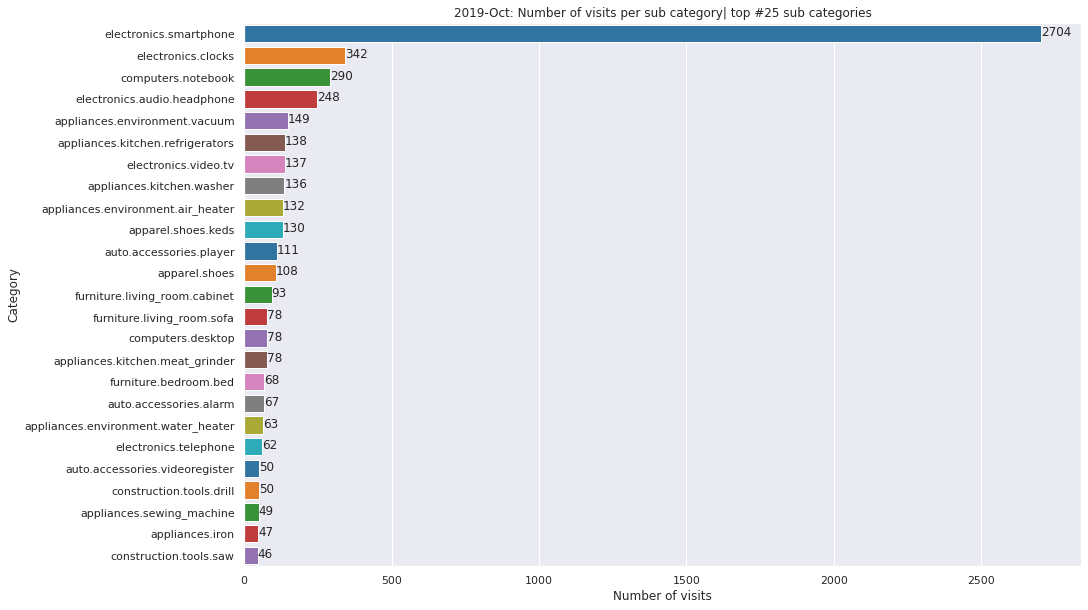

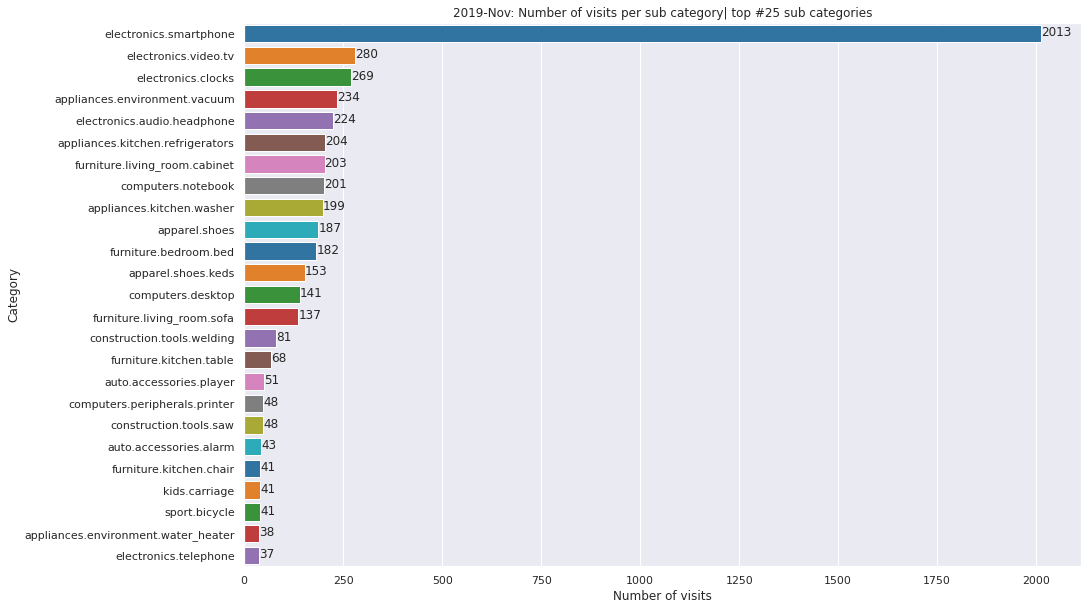

In [335]:
for df_label in df_labels:
    get_most_visited_sub_categories(df_label=df_label, top_n=25)

## What are the 10 most sold products per category?

Category - is the first value before . separator, the rest are sub-categories

In [368]:
# bash script is faster, can be used instead
def get_categories(df_label='2019-Oct', chunksize=100_000):
    reader = pd.read_csv(
        f"datasets/{df_label}.csv",
        usecols=['category_code'],
        dtype={'category_code': str},
        engine='c',
        na_filter=False,
        memory_map=True,
        chunksize=chunksize,
        nrows=300_000
    )
    all_categories = pd.DataFrame()
    for chunk in reader:
        chunk = chunk.replace('', np.nan).dropna()
        # take only the category
        chunk.loc[:, 'category_code'] = chunk.category_code.str.split('.').str[0]
        chunk.drop_duplicates(inplace=True)
        if all_categories.empty:
            all_categories = chunk
        else:
            all_categories = pd.concat([all_categories, chunk])
    all_categories = list(all_categories.category_code.unique())
    print(
        f"{df_label + ' | ' if df_label else ''}"
        f"Categories: "
    )
    print(all_categories)
    return all_categories

In [369]:
categories_dict = dict()
for df_label in df_labels:
    categories_dict[df_label] = get_categories(df_label=df_label)

2019-Oct | Categories: 
['appliances', 'furniture', 'computers', 'electronics', 'apparel', 'construction', 'auto', 'kids', 'sport', 'accessories', 'medicine', 'stationery', 'country_yard']
2019-Nov | Categories: 
['electronics', 'appliances', 'computers', 'furniture', 'apparel', 'construction', 'auto', 'accessories', 'kids', 'sport', 'medicine', 'country_yard', 'stationery']


In [377]:
def get_most_sold_products_per_category(category, df_label='2019-Oct', chunksize=100_000, top_n=10):
    reader = pd.read_csv(
        f"datasets/{df_label}.csv",
        usecols=['category_code', 'event_type', 'product_id'],
        dtype={'category_code': str, 'event_type': str, 'product_id': np.uint32},
        engine='c',
        na_filter=False,
        memory_map=True,
        chunksize=chunksize,
        nrows=300_000
    )
    most_sold_products = pd.DataFrame()
    i = 0
    for chunk in reader:
        # print(f"Processing a chunk #{i}")
        # take only the category
        chunk.loc[:, 'category_code'] = chunk.category_code.str.split('.').str[0]
        events_operations = chunk[
            chunk['event_type'].isin(['purchase']) 
            & (chunk['category_code'] == category)
        ].dropna().groupby(
            ['category_code', 'product_id']
        ).event_type.count().to_frame().rename(
            columns={'event_type': 'n_purchases'}
        )
        if most_sold_products.empty:
            most_sold_products = events_operations
        else:
            most_sold_products = \
                most_sold_products.add(events_operations, fill_value=0).astype(np.uint32)
        i += 1
    most_sold_products.reset_index(inplace=True)
    most_sold_products = most_sold_products.sort_values(by='n_purchases', ascending=False).head(top_n)
    top_n_sold_products = list(most_sold_products.product_id.values)
    print(
        f"{df_label + ' | ' if df_label else ''}"
        f"The 10 most sold products per '{category}' are:"
    )
    print(top_n_sold_products)
    print(most_sold_products)
        
    return top_n_sold_products

In [378]:
for df_label in df_labels:
    for category in categories_dict.get(df_label, list())[:1]:
        get_most_sold_products_per_category(category=category, df_label=df_label, top_n=10)

2019-Oct | The 10 most sold products per 'appliances' are:
[3900815, 3700926, 3600661, 3601244, 3601485, 3701134, 3601405, 3600163, 6300465, 3900003]
    category_code  product_id  n_purchases
252    appliances     3900815           18
193    appliances     3700926           17
130    appliances     3600661           15
140    appliances     3601244           10
158    appliances     3601485            9
204    appliances     3701134            8
148    appliances     3601405            7
123    appliances     3600163            7
313    appliances     6300465            7
238    appliances     3900003            7
2019-Nov | The 10 most sold products per 'electronics' are:
[1004856, 1004767, 1005115, 1004833, 4804056, 1004249, 1002544, 1004870, 1005105, 1004873]
    category_code  product_id  n_purchases
139   electronics     1004856          241
117   electronics     1004767          163
204   electronics     1005115          138
131   electronics     1004833          106
398   elect

# RQ3

 - For each category, **what’s the brand whose prices are higher on average?**
 

 - Write a function that asks the user a category in input and returns a **plot indicating the average price of the products sold by the brand.**
 
 
 - **Find, for each category, the brand with the highest average price.** 
 
   Return all the results in ascending order by price.

## For each category, what’s the brand whose prices are higher on average?

In [ ]:
# TODO

## Write a function that asks the user a category in input and returns a plot indicating the average price of the products sold by the brand.

In [ ]:
# TODO

## Find, for each category, the brand with the highest average price.

In [ ]:
# TODO

# RQ4

In [ ]:
# Add to the notebook

# RQ5

In [ ]:
# Add to the notebook

# RQ6

In [ ]:
# Add to the notebook

In [296]:
#coversion rate => (#purchase)/(#view)
#we can esealy use the subdataframe of RQ2

#sales is a sub that contain only purchased product
#sales = subRQ2[subRQ2['event_type']=='purchase']
product_sold = len(sales)


In [297]:
product_sold

682721

In [298]:
#while visited cointain only visited product
#visited = subRQ2[subRQ2['event_type']=='view']
product_watched = len(visited)

In [299]:
overall_conversion_rate = product_sold/product_watched
round(overall_conversion_rate,6)

0.015982

In [246]:
#RQ6.1 rate for each categories


In [300]:
# number of sales (calculated in RQ2)
number_of_sales
#we obtained a pandas series with the number of products sold

category_code
accessories       2154
apparel          14215
appliances       99026
auto             10719
computers        34477
construction      8699
country_yard        60
electronics     493639
furniture        11542
kids              6166
medicine           344
sport             1489
stationery         191
Name: product_id, dtype: int64

In [301]:
watched = subRQ2[subRQ2['event_type']=='view']

In [302]:
watched.head()

,event_type,product_id,category_code
0,view,1003461,electronics.smartphone
1,view,5000088,appliances.sewing_machine
3,view,3601530,appliances.kitchen.washer
4,view,1004775,electronics.smartphone
5,view,1306894,computers.notebook


In [ ]:
#s.str.split()

In [311]:
watched['category_code'].head()

0       electronics.smartphone
1    appliances.sewing_machine
3    appliances.kitchen.washer
4       electronics.smartphone
5           computers.notebook
Name: category_code, dtype: object

In [308]:
#watched['category_code'].str.split('.')

In [309]:
#watched['category_code']= watched['category_code'].str.split()[0]

In [312]:
watched['category_code'] = [el.split('.')[0] for el in list(watched['category_code']) if type(el) == str]

<ipython-input-312-d69c0d1f5796>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  watched['category_code'] = [el.split('.')[0] for el in list(watched['category_code']) if type(el) == str]


In [313]:
watched.head()

,event_type,product_id,category_code
0,view,1003461,electronics
1,view,5000088,appliances
3,view,3601530,appliances
4,view,1004775,electronics
5,view,1306894,computers


In [314]:
times_watched = watched.groupby('category_code').product_id.count()

In [381]:
times_watched
#we obtained a pandas series with the number o product view for aech category 

category_code
accessories       380373
apparel          2942622
appliances       8037980
auto             1164278
computers        4029049
construction     1047072
country_yard       17299
electronics     21988192
furniture        2058798
kids              779517
medicine           20764
sport             240763
stationery         11943
Name: product_id, dtype: int64

In [376]:
times_watched.head()

category_code
accessories     380373
apparel        2942622
appliances     8037980
auto           1164278
computers      4029049
Name: product_id, dtype: int64

In [318]:
number_of_sales.head()

category_code
accessories     2154
apparel        14215
appliances     99026
auto           10719
computers      34477
Name: product_id, dtype: int64

In [317]:
type(number_of_sales) == type(times_watched) 
#both elements are pandas series so we can just deviding them by using devide() command

True

In [383]:
#purchase rate of each category
purchase_rate = number_of_sales.divide(times_watched)
purchase_rate

category_code
accessories     0.005663
apparel         0.004831
appliances      0.012320
auto            0.009207
computers       0.008557
construction    0.008308
country_yard    0.003468
electronics     0.022450
furniture       0.005606
kids            0.007910
medicine        0.016567
sport           0.006185
stationery      0.015993
Name: product_id, dtype: float64

In [ ]:
#TODO recheck purchase rate vs conversion rate
#TODO plot 

# RQ7